# Imports

In [134]:
try:
  import iminuit
  from iminuit import Minuit
  from iminuit.cost import LeastSquares
except:
  Exception('Error Initialising Iminuit')

In [135]:
import os
from IPython.display import Latex
import sympy as sp
import scipy as sc
import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

# Funcs

In [136]:
#function for removing Nan values from a numpy array
def rNan(arr): return arr[~np.isnan(arr)]

In [137]:
#@title Test ipotesi
def chi_test(fval, ndof, x_limit = 40):
  '''This funciton visualizes the chi2 test for a given chi2 value and degrees of freedom
  Values
  -------

    `fval` : chi2 value

    `ndof` : degrees of freedom
    `x_limit` : chi2 value limit for integral (don't change)
  '''

  x = np.linspace(0,x_limit, 1000)
  y = [sc.stats.chi2.pdf(i,df=ndof) for i in x]

  section = np.arange(fval, x_limit)
  plt.fill_between(section,sc.stats.chi2.pdf(section,df=ndof), alpha=.4)
  plt.title('Test $\chi^2$')
  plt.xlabel(r'$\chi^2$')
  plt.ylabel('$pdf(\chi^2)$')
  plt.legend([r'$\tilde\chi^2$ '+f'= {round(fval/ndof,2)} \n p-value = {round(1 - sc.stats.chi2.cdf(fval,ndof),3)*100}%'])
  plt.plot(x,y)

def t_test(tvalue, df,xlim = 7, alpha = 0.05 ):
  '''This function visualizes the t Student test for a given t value and degrees of freedom
    Values:
    -------

    `tvalue` : t Student test Value
    `df` : dergrees of freedom
    `xlim` : limit for integration (don't change)
  '''

  x = np.linspace(-xlim,xlim,2000)
  y = [ sc.stats.t.pdf(i,df) for i in x]

  section1 = np.linspace(-xlim,-tvalue)
  plt.fill_between(section1,sc.stats.t.pdf(section1,df=df), alpha=.4, color='b')

  section2 = np.linspace(tvalue, xlim)
  plt.fill_between(section2,sc.stats.t.pdf(section2,df=df), alpha=.4, color='b')

  # plt.title('t Test')
  plt.xlabel(r't')
  plt.ylabel('pdf(t)')
  plt.legend([r'$\alpha$'+f' = {round((1-sc.stats.t.cdf(tvalue,df=df))*2, 4)}'])
  plt.plot(x,y)
  return (1-sc.stats.t.cdf(tvalue,df=df))*2

In [138]:
#@title Error Propagation no Covariance

def formula_errori(parametri:str, formula:str, latex_ = False):

    #convert from str to sympy
    parametri = sp.sympify(parametri)
    formula = sp.simplify(formula)
    sigmas = sp.symbols([f'sigma_{var}' for var in parametri])
    i,exp = 0,0

    for val in parametri:

        #squared partial derivatives and sigmas
        exp += sp.diff(formula,val)**2 * sigmas[i]**2
        i+=1

    exp = sp.sqrt(exp)

    if latex_: return '$'+sp.latex(exp)+'$'

    return (exp)

def valuta_errori(formula_errori:str, values:dict, errors:dict, x:dict=None):

  #convert minuit values method to dict
  params = values.keys()

  #sustitute numerical values
  expr = formula_errori.subs(values)

  for val in errors:

    #substitute numerical for sigmas
    expr = expr.subs(f'sigma_{val}', errors[val])

  if x != None: expr = expr.subs(x)

  return expr

In [139]:
# @title media pesata
def media_pesata(x,err) -> tuple['media','sigma']:

  x_ = np.array(x)
  err_ = np.array(err)

  if x_.shape != err_.shape:
    raise Exception('Size mismatch, control arrays!')
    return

  s1,s2 = 0,0
  for i,j in zip(x_,err_):

    s1 += i/j**2
    s2 += 1/j**2

  media = s1/s2
  sigma = np.sqrt(float(1/s2))

  return media,sigma

# Data

In [140]:
data = 'https://docs.google.com/spreadsheets/d/10J8iO8non_Iq_K_8JXAtarPfYMNR1pZCf4Qn8pPsk_4/'
df = pd.read_excel(data+'export?format=xlsx',sheet_name=None)
print(df.keys())

dict_keys(['RC', 'RL', 'RLC_sovra', 'RLC_sotto', 'RLC_crit'])


# other funcs

In [141]:
def find_file(path:str,name:str):
    for fname in os.listdir(path):    # change directory as needed
        if name in fname:
            return fname
    return None

In [142]:
def get_data(path:str):
    '''This function loads the data from the oscilloscope'''

    try:
        name = find_file(path,'CH1')
        if name != None:
            first_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float32) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float32)
        else:
            first_channel = None
    except:
        first_channel = None
        print('Error loading first channel')

    try:
        name = find_file(path,'CH2')
        if name != None:
            second_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float32) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float32)
        else:
            second_channel = None
    except:
        second_channel = None
        print('Error loading second channel')
        
    try:
        name = find_file(path,'MTH')
        if name != None:
            third_channel = pd.read_csv(path+name).iloc[:,3].to_numpy(np.float32) , pd.read_csv(path+name).iloc[:,4].to_numpy(np.float32)
        else:
            third_channel = first_channel[0], np.zeros(first_channel[0].shape)
    except:
        third_channel = first_channel[0], np.zeros(first_channel[0].shape)
        print('Error loading third channel')
    

    return first_channel, second_channel, third_channel

In [143]:
def V_RC(t,V_o,R,C,T, offset):
    return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C))))
    return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

def V_RC_2(t,V_o,R,C,T, offset):
    return -V_o*( 1 - 2*(np.exp(- ((t+offset)-(T/2)) /(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )

def exp1(t,V_o,R,C,offset):
    return V_o*np.exp(-t/(R*C)) + offset

# RC1 
<p1> R = 200 $\Omega$

In [144]:
RC_200_s_quadra, RC_200_s_data, RC_200_s_math  = get_data('data/RC_200_salita/')
RC_200_s_math = RC_200_s_data[0], (RC_200_s_quadra[1] - RC_200_s_data[1])

plt.title('RC - 200 $\Omega$')
plt.plot(RC_200_s_quadra[0],RC_200_s_quadra[1],c='darkslateblue')
plt.plot(RC_200_s_data[0],RC_200_s_data[1], c='firebrick')
plt.plot(RC_200_s_math[0],RC_200_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza'])
plt.close()

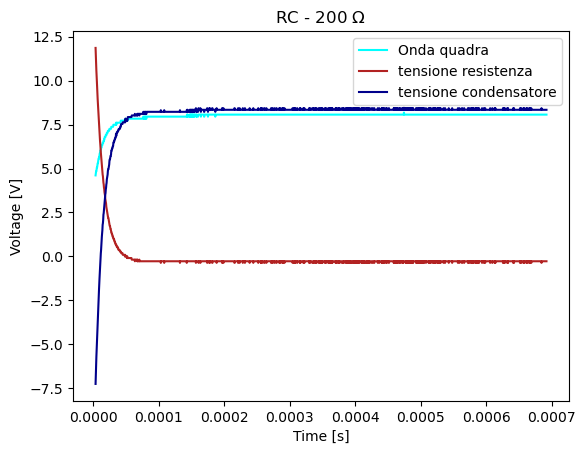

In [145]:
i = 0
v = RC_200_s_data[1][0]
while(v < np.max(RC_200_s_data[1])):
    v = RC_200_s_data[1][i]
    i+=1

plt.title('RC - 200 $\Omega$')
plt.plot(RC_200_s_quadra[0][i:],RC_200_s_quadra[1][i:], c='cyan')
plt.plot(RC_200_s_data[0][i:],  RC_200_s_data[1][i:],   c='firebrick')
plt.plot(RC_200_s_math[0][i:],  RC_200_s_math[1][i:],   c='darkblue')
# plt.xscale('log')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [146]:
c = LeastSquares(RC_200_s_math[0][i:],RC_200_s_math[1][i:], .01, exp1)
m = Minuit(c, R=250,V_o=8, C=49*1e-9, offset=0)
m.migrad()
m.hesse()
m.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.105e+04 (χ²/ndof = 41.4) │             Nfcn = 2233              │
│ EDM = 9.37e-09 (Goal: 0.0002)    │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  -19.558  │   0.006   │   -0.006   │   0.006    │         │         │       │
│ 1 │ R      │  1.549e3  │  0.004e3  │  -0.004e3  │  0.004e3   │         │         │       │
│ 2 │ C      │ 8.435e-9  │ 0.020e-9  │ -0.020e-9  │  0.020e-9  │         │         │       │
│ 3 │ offset │  8.33138  │  0.00025  │  -0.00025  │  0.00025   │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          V_o          │           R           │           C           │        offset         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.006   │   0.006   │    -4     │     4     │ -0.02e-9  │  0.02e-9  │ -0.25e-3  │  0.25e-3  │
│  Valid   │   True    │   True    │   False   │   False   │   False   │   False   │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────┐
│        │                V_o                  R                  C             offset │
├────────┼─────────────────────────────────────────────────────────────────────────────┤
│    V_o │           3.12e-05           1.180e-3      6.4288518e-15            0.08e-6 │
│      R │           1.180e-3               13.8 -74.3772439367e-12           13.07e-6 │
│      C │      6.4288518e-15 -74.3772439367e-12           4.09e-22        71.1897e-18 │
│ offset │            0.08e-6           13.07e-6        71.1897e-18           6.28e-08 │
└────────┴─────────────────────────────────────────────────────────────────────────────┘

In [148]:
c = LeastSquares(RC_200_s_math[0][i:],RC_200_s_math[1][i:], .001, V_RC)
m = Minuit(c, R=236.4	,V_o=8.35174, C=58.2e-9,T=0.025, offset=0)
m.fixed['T'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

/tmp/ipykernel_20269/242545784.py:2: RuntimeWarning: overflow encountered in exp
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C))))
/tmp/ipykernel_20269/242545784.py:2: RuntimeWarning: overflow encountered in multiply
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C))))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.693e+07 (χ²/ndof = 21494.3)│              Nfcn = 105              │
│ EDM = 2.07e+07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │ 8.351740  │ 0.000025  │            │            │         │         │       │
│ 1 │ R      │  244.31   │   0.06    │            │            │    0    │         │       │
│ 2 │ C      │ 62.181e-9 │ 0.016e-9  │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │    -0     │  0.4e-9   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │                V_o                  R                  C                  T             offset │
├────────┼────────────────────────────────────────────────────────────────────────────────────────────────┤
│    V_o │           6.29e-10            18.7e-9        4.56526e-18                  0        1.17088e-15 │
│      R │            18.7e-9              0.004 -1.01034728013e-12              0.000     1.18129898e-12 │
│      C │        4.56526e-18 -1.01034728013e-12           2.59e-22                  0           0.27e-21 │
│      T │                  0              0.000                  0                  0                  0 │
│ offset │        1.17088e-15     1.18129898e-12           0.27e-21                  0           1.41e-19 │
└────────┴────────────────────────────────────────────────────────────────────────────────────────────────┘

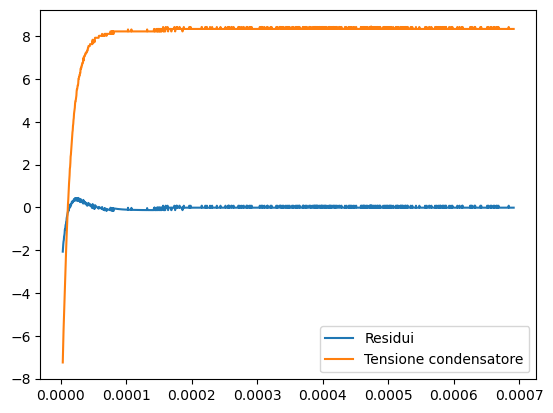

In [ ]:
resti = [i-j for i,j in zip(RC_200_s_math[1][i:],V_RC(RC_200_s_math[0][i:],m.values['V_o'],m.values['R'],m.values['C'],m.values['T'],m.values['offset']))]
plt.plot(RC_200_s_math[0][i:],resti)
plt.plot(RC_200_s_math[0][i:],RC_200_s_math[1][i:])
# plt.plot(RC_200_s_math[0][i:], RC_200_s_math[1][i:] + resti)
plt.legend(['Residui','Tensione condensatore'])

# RC2 
<p1> R = 400 $\Omega$

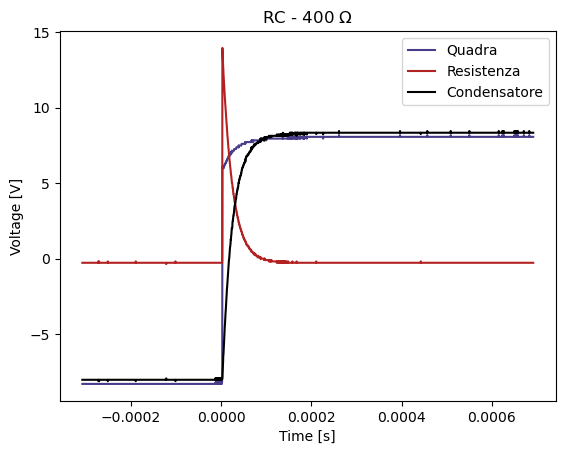

In [ ]:
RC_400_s_quadra, RC_400_s_data, RC_400_s_math  = get_data('data/RC_400_salita/')
RC_400_s_math = RC_400_s_data[0], (RC_400_s_quadra[1] - RC_400_s_data[1])

plt.title('RC - 400 $\Omega$')
plt.plot(RC_400_s_quadra[0],RC_400_s_quadra[1],c='darkslateblue')
plt.plot(RC_400_s_data[0],RC_400_s_data[1], c='firebrick')
plt.plot(RC_400_s_math[0],RC_400_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza','Condensatore'])
plt.show()

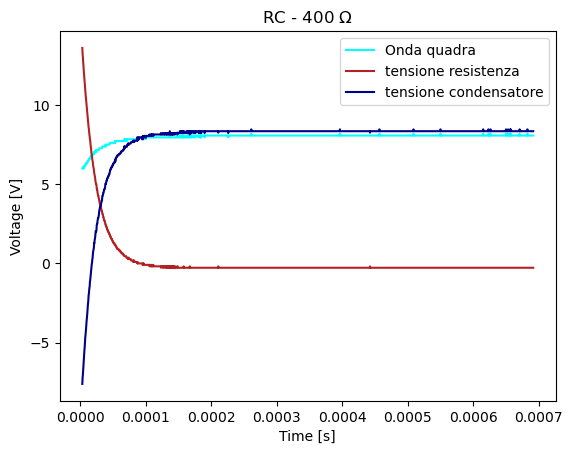

In [ ]:
i = 0
v = RC_400_s_data[1][0]
while(v < np.max(RC_400_s_data[1])):
    v = RC_400_s_data[1][i]
    i+=1

plt.title('RC - 400 $\Omega$')
plt.plot(RC_400_s_quadra[0][i:],RC_400_s_quadra[1][i:],c='cyan')
plt.plot(RC_400_s_data[0][i:],RC_400_s_data[1][i:], c='firebrick')
plt.plot(RC_400_s_math[0][i:],RC_400_s_math[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [ ]:
c = LeastSquares(RC_400_s_math[0][i:],RC_400_s_math[1][i:], .01, V_RC)
m = Minuit(c, R=400	,V_o=8.35174, C=58.2e-9,T=0.025, offset=0)
m.fixed['T'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

/tmp/ipykernel_20269/221220561.py:2: RuntimeWarning: overflow encountered in exp
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.293e+05 (χ²/ndof = 133.4)│              Nfcn = 105              │
│ EDM = 2.38e+05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  8.34679  │  0.00026  │            │            │         │         │       │
│ 1 │ R      │   410.4   │    0.8    │            │            │    0    │         │       │
│ 2 │ C      │ 61.28e-9  │  0.12e-9  │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │   -0e-9   │   6e-9    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬───────────────────────────────────────────────────────────────────────────────────────────┐
│        │               V_o                 R                 C                 T            offset │
├────────┼───────────────────────────────────────────────────────────────────────────────────────────┤
│    V_o │          6.83e-08           4.26e-6       641.503e-18                 0       319.115e-15 │
│      R │           4.26e-6             0.676 -99.920531360e-12               0.0    258.605404e-12 │
│      C │       641.503e-18 -99.920531360e-12          1.51e-20                 0         0.039e-18 │
│      T │                 0               0.0                 0                 0                 0 │
│ offset │       319.115e-15    258.605404e-12         0.039e-18                 0          3.07e-17 │
└────────┴───────────────────────────────────────────────────────────────────────────────────────────┘

# RC3 
<p1> R = 2k $\Omega$

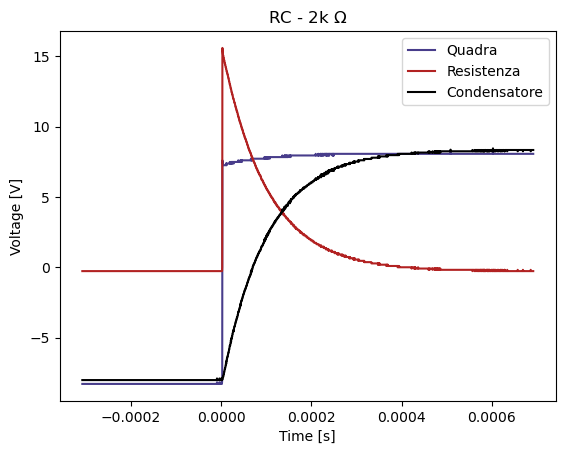

In [ ]:
RC_2k_s_quadra, RC_2k_s_data, RC_2k_s_math  = get_data('data/RC_2k_salita/')
RC_2k_s_math = RC_2k_s_data[0], (RC_2k_s_quadra[1] - RC_2k_s_data[1])

plt.title('RC - 2k $\Omega$')
plt.plot(RC_2k_s_quadra[0],RC_2k_s_quadra[1],c='darkslateblue')
plt.plot(RC_2k_s_data[0],RC_2k_s_data[1], c='firebrick')
plt.plot(RC_2k_s_math[0],RC_2k_s_math[1], c='black')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Quadra','Resistenza','Condensatore'])
plt.show()

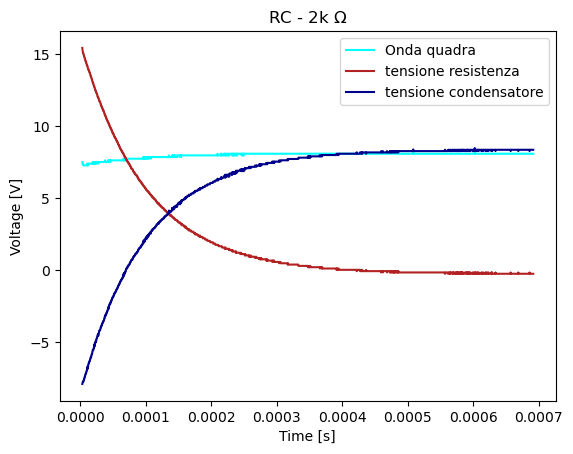

In [ ]:
i = 0
v = RC_2k_s_data[1][0]
while(v < np.max(RC_2k_s_data[1])):
    v = RC_2k_s_data[1][i]
    i+=1

plt.title('RC - 2k $\Omega$')
plt.plot(RC_2k_s_quadra[0][i:],RC_2k_s_quadra[1][i:],c='cyan')
plt.plot(RC_2k_s_data[0][i:],RC_2k_s_data[1][i:], c='firebrick')
plt.plot(RC_2k_s_math[0][i:],RC_2k_s_math[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.show()

In [ ]:
c = LeastSquares(RC_2k_s_math[0][i:],RC_2k_s_math[1][i:], .01, V_RC)
m = Minuit(c, R=2000	,V_o=8.35174, C=58.2e-9,T=0.025, offset=0)
m.fixed['T'] = True
m.limits['C','R'] = (0,np.inf)
m.migrad()
m.hesse()

/tmp/ipykernel_20269/221220561.py:2: RuntimeWarning: overflow encountered in exp
  return V_o*( 1 - 2*(np.exp(-(t+offset)/(R*C)) / (1+np.exp( -T/(R*C) ) ) ) )


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.584e+04 (χ²/ndof = 15.0) │              Nfcn = 172              │
│ EDM = 8.38e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o    │  8.3472   │  0.0004   │            │            │         │         │       │
│ 1 │ R      │ 1.8539e3  │ 0.0019e3  │            │            │    0    │         │       │
│ 2 │ C      │ 53.86e-9  │  0.05e-9  │            │            │    0    │         │       │
│ 3 │ T      │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
│ 4 │ offset │ -1.325e-6 │ 0.009e-6  │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────┐
│        │                 V_o                   R                   C                   T              offset │
├────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    V_o │            1.34e-07            29.65e-6        862.6136e-18                   0         1.62179e-12 │
│      R │            29.65e-6                3.55 -102.0949244471e-12                   0       922.04932e-12 │
│      C │        862.6136e-18 -102.0949244471e-12            2.99e-21               0e-21            26.8e-21 │
│      T │                   0                   0               0e-21                   0                   0 │
│ offset │         1.62179e-12       922.04932e-12            26.8e-21                   0            8.05e-17 │
└────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────┘

# Funcs

In [ ]:
def V_RL(t,V_o,R,L,T):
    return V_o* 2*(np.exp(-t*R/L) / (1 + np.exp( -T*R/L) ) )

def V_RL_2(t,V_o,R,L,T):
    return V_o* 2*(np.exp(-(t-(T/2))*R/L) / (1 + np.exp( -T*R/L) ) )

In [ ]:
def V_RL_basic(t,V_o,tau,c):
    return V_o*(np.exp(-t/tau))+c

# RL1
<p1> R = 100 $\Omega$

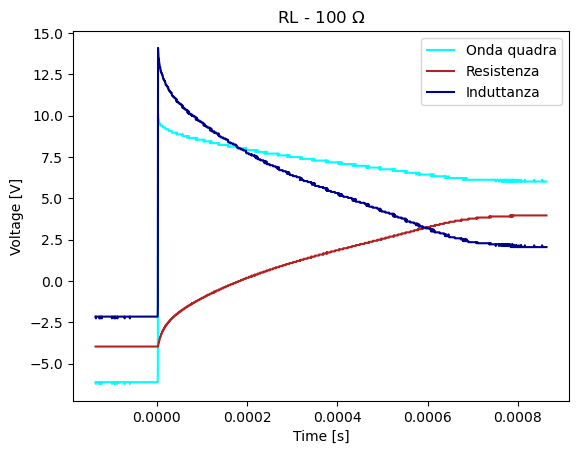

In [ ]:
RL_100_s_quadra, RL_100_s_res, RL_100_s_ind  = get_data('data/RL_100_salita/')

RL_100_s_ind = RL_100_s_res[0], (RL_100_s_quadra[1] - RL_100_s_res[1])
plt.title('RL - 100 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')

plt.plot(RL_100_s_quadra[0],    RL_100_s_quadra[1],                     c='cyan')
plt.plot(RL_100_s_res[0],       RL_100_s_res[1],                        c='firebrick')
plt.plot(RL_100_s_ind[0],    RL_100_s_ind[1],   c='darkblue')

plt.legend(['Onda quadra','Resistenza','Induttanza'])

In [ ]:
i = 0
v = RL_100_s_ind[1][0]
print(v)
while(v < np.max(RL_100_s_res[1])):
    v = RL_100_s_ind[1][i]
    i+=1
print(i)
plt.title('RL - 100 $\Omega$')
plt.plot(RL_100_s_quadra[0][i:],RL_100_s_quadra[1][i:],c='cyan')
plt.plot(RL_100_s_res[0][i:],RL_100_s_res[1][i:], c='firebrick')
plt.plot(RL_100_s_ind[0][i:],RL_100_s_ind[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.close()

-2.1568003
347


In [ ]:
c = LeastSquares(RL_100_s_ind[0][347:],RL_100_s_ind[1][347:], .1, V_RL)
m = Minuit(c, R = 100,V_o=8, T=0.025, L=1e-3)
m.limits['L','R'] = (0,np.inf)
m.fixed['T'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8800 (χ²/ndof = 4.1)       │              Nfcn = 121              │
│ EDM = 1.75e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │  6.0965   │  0.0032   │            │            │         │         │       │
│ 1 │ R    │   1.49    │   0.32    │            │            │    0    │         │       │
│ 2 │ L    │  0.68e-3  │  0.15e-3  │            │            │    0    │         │       │
│ 3 │ T    │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────┐
│     │       V_o         R         L         T │
├─────┼─────────────────────────────────────────┤
│ V_o │  1.04e-05 -0.003e-3 -0.003e-6         0 │
│   R │ -0.003e-3     0.103 47.104e-6       0.0 │
│   L │ -0.003e-6 47.104e-6  2.15e-08         0 │
│   T │         0       0.0         0         0 │
└─────┴─────────────────────────────────────────┘

# RL2
<p1> R = 400 $\Omega$

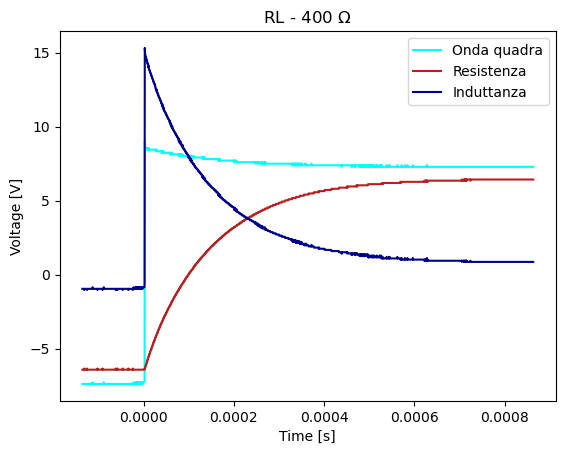

In [ ]:
RL_400_s_quadra, RL_400_s_res, RL_400_s_ind  = get_data('data/RL_400_salita/')
RL_400_s_ind = RL_400_s_res[0], (RL_400_s_quadra[1] - RL_400_s_res[1])

plt.title('RL - 400 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RL_400_s_quadra[0],    RL_400_s_quadra[1],                     c='cyan')
plt.plot(RL_400_s_res[0],       RL_400_s_res[1],                        c='firebrick')
plt.plot(RL_400_s_ind[0],       RL_400_s_ind[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Induttanza'])
plt.show()

In [ ]:
i = 0
v = RL_400_s_ind[1][0]
print(v)
while(v < np.max(RL_400_s_res[1])):
    v = RL_400_s_ind[1][i]
    i+=1
print(i)
plt.title('RL - 400 $\Omega$')
plt.plot(RL_400_s_quadra[0][i:],RL_400_s_quadra[1][i:],c='cyan')
plt.plot(RL_400_s_res[0][i:],RL_400_s_res[1][i:], c='firebrick')
plt.plot(RL_400_s_ind[0][i:],RL_400_s_ind[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.close()

-0.9632001
347


In [ ]:
c = LeastSquares(RL_100_s_ind[0][347:],RL_100_s_ind[1][347:], .1, V_RL)
m = Minuit(c, R = 400,V_o=6, T=0.025, L=25e-3)
m.limits['L','R'] = (0,np.inf)
m.fixed['T'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8800 (χ²/ndof = 4.1)       │              Nfcn = 107              │
│ EDM = 1.07e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │  6.0965   │  0.0032   │            │            │         │         │       │
│ 1 │ R    │    59     │    12     │            │            │    0    │         │       │
│ 2 │ L    │   0.027   │   0.005   │            │            │    0    │         │       │
│ 3 │ T    │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────┐
│     │       V_o         R         L         T │
├─────┼─────────────────────────────────────────┤
│ V_o │  1.04e-05  -0.07e-3        -0         0 │
│   R │  -0.07e-3       140 63.817e-3         0 │
│   L │        -0 63.817e-3  2.91e-05         0 │
│   T │         0         0         0         0 │
└─────┴─────────────────────────────────────────┘

# RL3
<p1> R = 1k $\Omega$

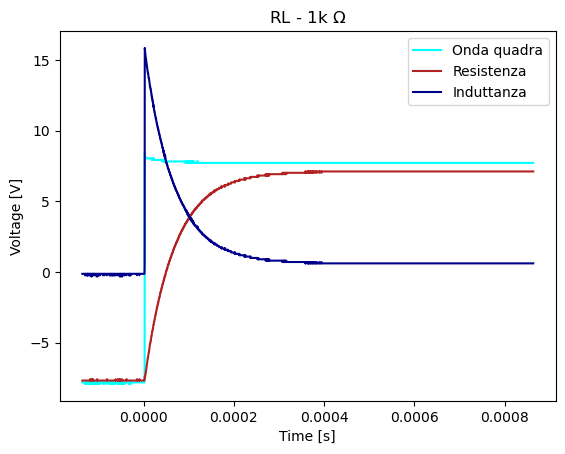

In [ ]:
RL_1k_s_quadra, RL_1k_s_res, RL_1k_s_ind  = get_data('data/RL_1k_salita/')
RL_1k_s_ind = RL_1k_s_res[0], (RL_1k_s_quadra[1] - RL_1k_s_res[1])

plt.title('RL - 1k $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RL_1k_s_quadra[0],    RL_1k_s_quadra[1],                     c='cyan')
plt.plot(RL_1k_s_res[0],       RL_1k_s_res[1],                        c='firebrick')
plt.plot(RL_1k_s_ind[0],       RL_1k_s_ind[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Induttanza'])
plt.show()

In [ ]:
i = 0
v = RL_1k_s_ind[1][0]
print(v)
while(v < np.max(RL_1k_s_res[1])):
    v = RL_1k_s_ind[1][i]
    i+=1
print(i)
plt.title('RL - 1k $\Omega$')
plt.plot(RL_1k_s_quadra[0][i:],RL_1k_s_quadra[1][i:],c='cyan')
plt.plot(RL_1k_s_res[0][i:],RL_1k_s_res[1][i:], c='firebrick')
plt.plot(RL_1k_s_ind[0][i:],RL_1k_s_ind[1][i:], c='darkblue')

plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(['Onda quadra','tensione resistenza', 'tensione condensatore'])
plt.close()

-0.13440037
347


In [ ]:
c = LeastSquares(RL_1k_s_ind[0][347:],RL_1k_s_ind[1][347:], .1, V_RL)
m = Minuit(c, R = 1000,V_o=6, T=0.025, L=25e-3)
m.limits['L','R'] = (0,np.inf)
m.fixed['T'] = True
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.246e+04 (χ²/ndof = 24.4) │              Nfcn = 121              │
│ EDM = 7.98e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │   7.704   │   0.008   │            │            │         │         │       │
│ 1 │ R    │    292    │     4     │            │            │    0    │         │       │
│ 2 │ L    │ 22.78e-3  │  0.30e-3  │            │            │    0    │         │       │
│ 3 │ T    │ 25.00e-3  │  0.25e-3  │            │            │         │         │  yes  │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────┐
│     │        V_o          R          L          T │
├─────┼─────────────────────────────────────────────┤
│ V_o │   6.63e-05    1.36e-3   -0.11e-6          0 │
│   R │    1.36e-3         15 1.16296e-3          0 │
│   L │   -0.11e-6 1.16296e-3   9.12e-08          0 │
│   T │          0          0          0          0 │
└─────┴─────────────────────────────────────────────┘

# Funcs

In [ ]:
# def V_RLC_st(t,V_o,R,L,C):
#     '''tensione in regime sottosmorzato'''
#     betha = np.sqrt( (1/(L*C))**2 - (R/L)**2 )
#     return V_o*np.exp(-t*R/L)*np.sin(t*betha)

In [ ]:
# def V_RLC_sv(t,V_o,R,L,C):
#     '''tensione in regime sovrasmorzato'''
#     betha = np.sqrt( (R/L)**2 - (1/(L*C))**2 )
#     return V_o*np.exp(-t*R/L)*[np.exp(t*betha) - np.exp(-t*betha)]

In [ ]:
# def V_RLC_crt(t,V_o,R,L,C):
#     '''tensione in regime critico'''
#     return V_o*t*np.exp(-t*R/L)

In [ ]:
def V_RLC_1(t,V_o,R,L,C):
    return V_o*np.exp(-t*R/L)*np.sin(t*np.sqrt(1/(L*C) - (R/L)**2))

In [ ]:
def V_RLC_2(t,V_o,R,L,C):
    betha = np.sqrt( (1/(L*C))**2 - (R/L)**2 )
    return V_o*np.exp(-t*R/L)*np.sin(t*betha)

# RLC - sottosmorzato
<p1> R = 30 $\Omega$

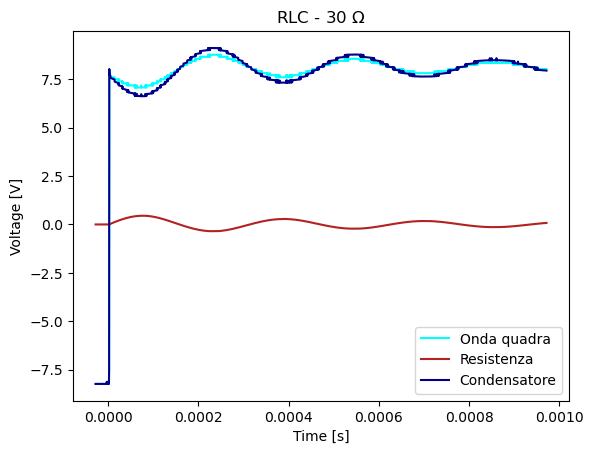

In [ ]:
RLC_30_quadra, RLC_30_res, RLC_30_math = get_data('data/RLC_30/')
RLC_30_math = RLC_30_res[0], (RLC_30_quadra[1] - RLC_30_res[1])

plt.title('RLC - 30 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_30_quadra[0],    RLC_30_quadra[1],                     c='cyan')
plt.plot(RLC_30_res[0],       RLC_30_res[1],                        c='firebrick')
plt.plot(RLC_30_math[0],       RLC_30_math[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

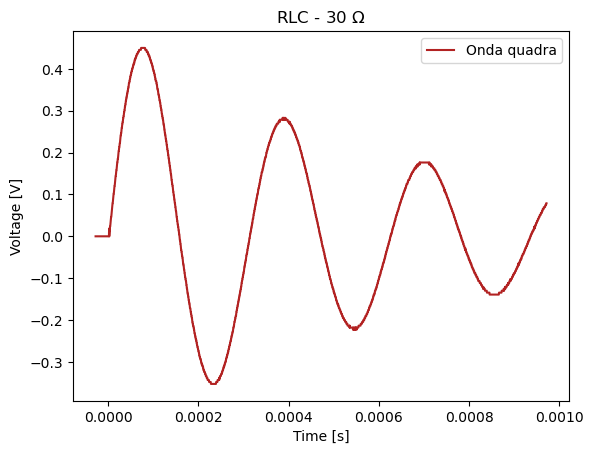

In [ ]:
plt.title('RLC - 30 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_30_res[0],       RLC_30_res[1],                        c='firebrick')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

76


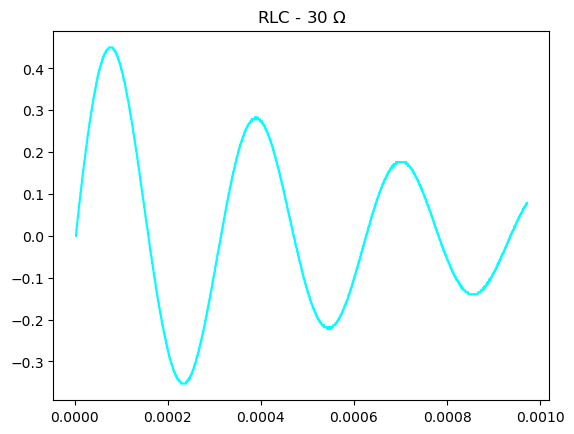

In [ ]:
i = 0
v = RLC_30_res[1][0]

while(v < 0.001):
    v = RLC_30_res[1][i]
    i+=1
print(i)
plt.title('RLC - 30 $\Omega$')
plt.plot(RLC_30_res[0][i:],RLC_30_res[1][i:],c='cyan')

In [ ]:
c = LeastSquares(RLC_30_res[0][i:],RLC_30_res[1][i:], .001, V_RLC_1)
m = Minuit(c, R = 30,V_o=8, L=30e-3, C=50*1e-9)
m.limits['L','R','C'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.083e+05 (χ²/ndof = 44.8) │              Nfcn = 408              │
│ EDM = 3.16e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │ 496.37e-3 │  0.08e-3  │            │            │         │         │       │
│ 1 │ R    │   24.57   │   0.22    │            │            │    0    │         │       │
│ 2 │ L    │ 16.66e-3  │  0.15e-3  │            │            │    0    │         │       │
│ 3 │ C    │ 148.5e-9  │  1.4e-9   │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────┐
│     │              V_o                R                L                C │
├─────┼─────────────────────────────────────────────────────────────────────┤
│ V_o │          6.4e-09           416e-9            -0e-9        261.0e-18 │
│   R │           416e-9           0.0502        33.972e-6 -302.8793675e-12 │
│   L │            -0e-9        33.972e-6          2.3e-08    -205.3576e-15 │
│   C │        261.0e-18 -302.8793675e-12    -205.3576e-15         1.83e-18 │
└─────┴─────────────────────────────────────────────────────────────────────┘

# RLC - sottosmorzato
<p1> R = 200 $\Omega$

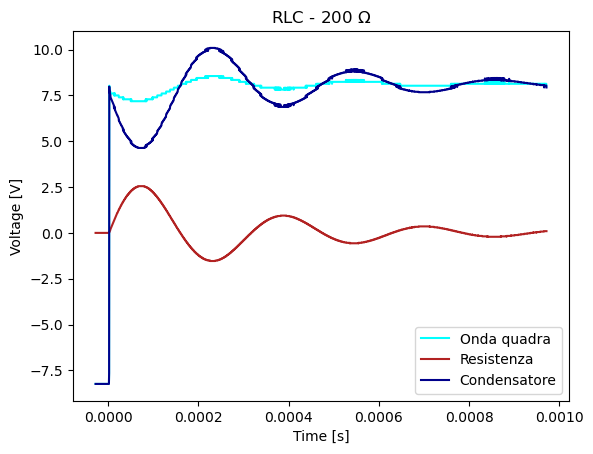

In [ ]:
RLC_200_quadra, RLC_200_res, RLC_200_math = get_data('data/RLC_200/')
RLC_200_math = RLC_200_res[0], (RLC_200_quadra[1] - RLC_200_res[1])

plt.title('RLC - 200 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_200_quadra[0],    RLC_200_quadra[1],                     c='cyan')
plt.plot(RLC_200_res[0],       RLC_200_res[1],                        c='firebrick')
plt.plot(RLC_200_math[0],       RLC_200_math[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

76


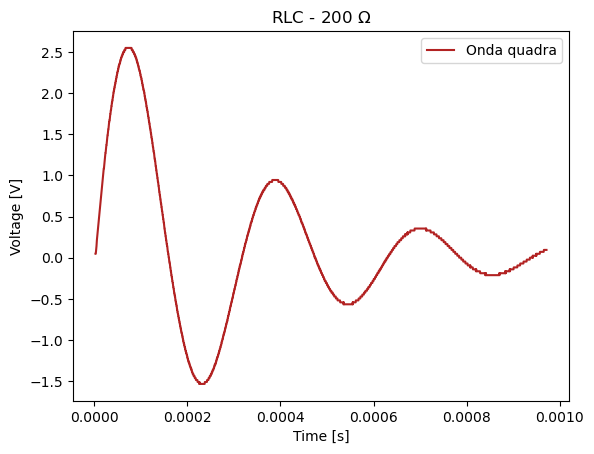

In [ ]:
i = 0
v = RLC_200_res[1][0]

while(v < 0.001):
    v = RLC_200_res[1][i]
    i+=1
print(i)

plt.title('RLC - 200 $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_200_res[0][i:],       RLC_200_res[1][i:],                        c='firebrick')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

In [ ]:
c = LeastSquares(RLC_200_res[0][i:],RLC_200_res[1][i:], .001, V_RLC_1)
m = Minuit(c, R = 200,V_o=8, L=30e-3, C=50*1e-9)
m.limits['L','R','C'] = (0,np.inf)
m.migrad()
m.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3.29e+06 (χ²/ndof = 1360.0)│              Nfcn = 175              │
│ EDM = 9.58e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │  3.19920  │  0.00011  │            │            │         │         │       │
│ 1 │ R    │  158.603  │   0.025   │            │            │    0    │         │       │
│ 2 │ L    │ 50.572e-3 │ 0.008e-3  │            │            │    0    │         │       │
│ 3 │ C    │ 49.098e-9 │ 0.007e-9  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────────────────────────────────────────────────────────────┐
│     │               V_o                 R                 L                 C │
├─────┼─────────────────────────────────────────────────────────────────────────┤
│ V_o │          1.14e-08          0.565e-6          -0.01e-9       5.09861e-18 │
│   R │          0.565e-6          0.000631         183.87e-9 -178.75545240e-15 │
│   L │          -0.01e-9         183.87e-9           5.9e-11     -57.15115e-18 │
│   C │       5.09861e-18 -178.75545240e-15     -57.15115e-18          5.56e-23 │
└─────┴─────────────────────────────────────────────────────────────────────────┘

# RLC - sovrasmorzato
<p1> R = 1k $\Omega$

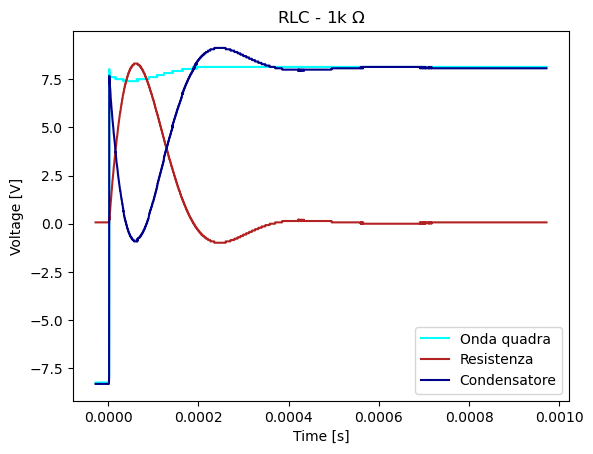

In [ ]:
RLC_1k_quadra, RLC_1k_res, RLC_1k_math = get_data('data/RLC_1k/')
RLC_1k_math = RLC_1k_res[0], (RLC_1k_quadra[1] - RLC_1k_res[1])

plt.title('RLC - 1k $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_1k_quadra[0],    RLC_1k_quadra[1],                     c='cyan')
plt.plot(RLC_1k_res[0],       RLC_1k_res[1],                        c='firebrick')
plt.plot(RLC_1k_math[0],       RLC_1k_math[1],                        c='darkblue')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

0


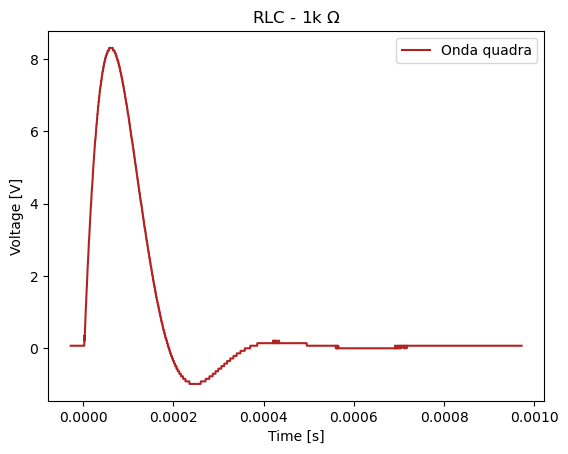

In [ ]:
i = 0
v = RLC_1k_res[1][0]

while(v < 0.001):
    v = RLC_1k_res[1][i]
    i+=1
print(i)

plt.title('RLC - 1k $\Omega$')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.plot(RLC_1k_res[0][i:],       RLC_1k_res[1][i:],                        c='firebrick')
plt.legend(['Onda quadra','Resistenza','Condensatore'])
plt.show()

In [ ]:
c = LeastSquares(RLC_1k_res[0][i:],RLC_1k_res[1][i:], .001, V_RLC_1)
m = Minuit(c, R = 1000,V_o=8, L=30e-3, C=50*1e-9)
m.limits['L','R','C'] = (0,np.inf)
m.migrad()
m.hesse()

/tmp/ipykernel_20269/3985288415.py:2: RuntimeWarning: invalid value encountered in sqrt
  return V_o*np.exp(-t*R/L)*np.sin(t*np.sqrt(1/(L*C) - (R/L)**2))


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 390              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ V_o  │     8     │    nan    │            │            │         │         │       │
│ 1 │ R    │    1e3    │    nan    │            │            │    0    │         │       │
│ 2 │ L    │   3e-2    │    nan    │            │            │    0    │         │       │
│ 3 │ C    │   5e-8    │    nan    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────┬─────────────────┐
│     │ V_o   R   L   C │
├─────┼─────────────────┤
│ V_o │ nan nan nan nan │
│   R │ nan nan nan nan │
│   L │ nan nan nan nan │
│   C │ nan nan nan nan │
└─────┴─────────────────┘